In [1]:
from bs4 import BeautifulSoup
import glob
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
def get_real_estate_type(soup, s):
    real_estate_types = ['Căn hộ chung cư',
        'Chung cư mini, căn hộ dịch vụ',
        'Nhà riêng',
        'Nhà biệt thự, liền kề',
        'Nhà mặt phố',
        'Shophouse, nhà phố thương mại',
        'Đất nền dự án',
        'Bán đất',
        'Trang trại, khu nghỉ dưỡng',
        'Condotel',
        'Kho, nhà xưởng',
        'Loại bất động sản khác']

    
    for item in real_estate_types:
        if item in s:
            return item
    return None



def get_details(soup):
    content_items = soup.find_all('div', class_="re__pr-specs-content-item")
    content = {}
    for item in content_items:
        key = item.find('span', class_='re__pr-specs-content-item-title').text
        value = item.find('span', class_='re__pr-specs-content-item-value').text
        content[key] = value
    try:
        content['Khu vực'] = soup.find('a', {'level': '3'}).text
        content['Loại bất động sản'] = get_real_estate_type(soup, soup.find('a', {'level': '4'}).text)
    except:
        content['Khu vực'] = None
        content['Loại bất động sản'] = None

    return content

In [3]:
html_files = glob.glob('data/*.html')

feature_names = []
list_post_details = []
for html_file in html_files:
    with open(html_file, "r", encoding="utf-8") as file:
        content = file.read()

    soup = BeautifulSoup(content, 'html.parser')
    content = get_details(soup)
    list_post_details.append(content)
    
    for item in content:
        if item not in feature_names:
            feature_names.append(item)



In [4]:
feature_names


['Diện tích',
 'Mức giá',
 'Mặt tiền',
 'Đường vào',
 'Số tầng',
 'Pháp lý',
 'Nội thất',
 'Khu vực',
 'Loại bất động sản',
 'Hướng nhà',
 'Hướng ban công',
 'Số phòng ngủ',
 'Số toilet']

In [5]:

df = pd.DataFrame(columns=feature_names)
new_rows_df = pd.DataFrame(list_post_details)
df = pd.concat([df, new_rows_df], ignore_index=True)
df.to_csv('unclean_data.csv', index=False)

In [13]:
df = pd.read_csv('unclean_data.csv')

In [14]:
print(df.shape)
df.head()

(24277, 13)


,Diện tích,Mức giá,Mặt tiền,Pháp lý,Khu vực,Loại bất động sản,Đường vào,Hướng ban công,Số phòng ngủ,Số toilet,Nội thất,Số tầng,Hướng nhà
0,94 m²,35 tỷ,"6,3 m",Sổ đỏ/ Sổ hồng,Hoàn Kiếm,Bán đất,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52 m²,"52,94 triệu/m²","4,3 m",Sổ đỏ/ Sổ hồng,Hoài Đức,Bán đất,10 m,NaN,NaN,NaN,NaN,NaN,NaN
2,"99,6 m²","5,2 tỷ",NaN,Sổ đỏ/ Sổ hồng,Nam Từ Liêm,Căn hộ chung cư,NaN,Đông - Nam,3 phòng,2 phòng,Đầy đủ,NaN,NaN
3,63 m²,"14,8 tỷ",NaN,Sổ đỏ/ Sổ hồng,Hà Đông,Nhà riêng,20 m,NaN,6 phòng,7 phòng,Đầy đủ,7 tầng,NaN
4,70 m²,Thỏa thuận,"4,5 m",Sổ đỏ/ Sổ hồng,Gia Lâm,Bán đất,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
non_empty_counts = df.count()
print(non_empty_counts)

Diện tích            23825
Mức giá              23825
Mặt tiền             11749
Pháp lý              20749
Khu vực              23836
Loại bất động sản    23836
Đường vào             8457
Hướng ban công        5091
Số phòng ngủ         15354
Số toilet            13997
Nội thất             13463
Số tầng              12137
Hướng nhà             6968
dtype: int64


In [16]:
def extract_float(s):
    if not s:
        return None
    if pd.isna(s):
        return None
    match = re.search(r'\d+(\.\d+)?', s)
    if match:
        return float(match.group())
    return None


def extract_integer(s):
    if not s:
        return None
    if pd.isna(s):
        return None
    match = re.search(r'\d+', s)
    if match:
        return int(match.group())
    return None

def convert_price_to_billion(price_str):
    if not price_str:
        return None
    if pd.isna(price_str):
        return None
    if price_str == 'Thỏa thuận':
        return None
    price_str = price_str.lower()
    pattern = re.findall(r'(\d+(?:,\d+)?)\s*(tỷ|triệu)', price_str)
    total_price_in_billion = 0
    for value, unit in pattern:
        value = float(value.replace(',', '.'))
        if unit == "tỷ":
            total_price_in_billion += value
        elif unit == "triệu":
            total_price_in_billion += value / 1000
    return total_price_in_billion

In [17]:
new_df = df.copy()

new_df['Diện tích'] = new_df['Diện tích'].apply(extract_float)
new_df['Mức giá'] = new_df['Mức giá'].apply(convert_price_to_billion)
new_df['Đường vào'] = new_df['Đường vào'].apply(extract_float)
new_df['Mặt tiền'] = new_df['Mặt tiền'].apply(extract_float)
new_df['Số phòng ngủ'] = new_df['Số phòng ngủ'].apply(extract_integer)
new_df['Số toilet'] = new_df['Số toilet'].apply(extract_integer)
new_df['Số tầng'] = new_df['Số tầng'].apply(extract_integer)


In [18]:
print(new_df.shape)
new_df.head()

(24277, 13)


,Diện tích,Mức giá,Mặt tiền,Pháp lý,Khu vực,Loại bất động sản,Đường vào,Hướng ban công,Số phòng ngủ,Số toilet,Nội thất,Số tầng,Hướng nhà
0,94.0,35.00000,6.0,Sổ đỏ/ Sổ hồng,Hoàn Kiếm,Bán đất,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52.0,0.05294,4.0,Sổ đỏ/ Sổ hồng,Hoài Đức,Bán đất,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2,99.0,5.20000,NaN,Sổ đỏ/ Sổ hồng,Nam Từ Liêm,Căn hộ chung cư,NaN,Đông - Nam,3.0,2.0,Đầy đủ,NaN,NaN
3,63.0,14.80000,NaN,Sổ đỏ/ Sổ hồng,Hà Đông,Nhà riêng,20.0,NaN,6.0,7.0,Đầy đủ,7.0,NaN
4,70.0,NaN,4.0,Sổ đỏ/ Sổ hồng,Gia Lâm,Bán đất,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
new_df.dropna(subset=['Mức giá'], inplace=True)
print(new_df.shape)
new_df.head(10)

(20437, 13)


,Diện tích,Mức giá,Mặt tiền,Pháp lý,Khu vực,Loại bất động sản,Đường vào,Hướng ban công,Số phòng ngủ,Số toilet,Nội thất,Số tầng,Hướng nhà
0,94.0,35.00000,6.0,Sổ đỏ/ Sổ hồng,Hoàn Kiếm,Bán đất,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52.0,0.05294,4.0,Sổ đỏ/ Sổ hồng,Hoài Đức,Bán đất,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2,99.0,5.20000,NaN,Sổ đỏ/ Sổ hồng,Nam Từ Liêm,Căn hộ chung cư,NaN,Đông - Nam,3.0,2.0,Đầy đủ,NaN,NaN
3,63.0,14.80000,NaN,Sổ đỏ/ Sổ hồng,Hà Đông,Nhà riêng,20.0,NaN,6.0,7.0,Đầy đủ,7.0,NaN
5,64.0,0.02800,4.0,Sổ đỏ/ Sổ hồng,Sóc Sơn,Bán đất,4.0,NaN,NaN,NaN,NaN,NaN,Nam
8,120.0,6.70000,NaN,Sổ đỏ/ Sổ hồng,Cầu Giấy,Căn hộ chung cư,NaN,Đông - Nam,3.0,2.0,Đầy đủ,NaN,Tây - Bắc
9,41.0,11.00000,3.0,Sổ đỏ/ Sổ hồng.,Hoàng Mai,Nhà riêng,10.0,Đông,6.0,4.0,NaN,6.0,Đông
10,126.0,30.00000,6.0,Sổ đỏ/ Sổ hồng.,Hoàng Mai,Nhà mặt phố,NaN,NaN,NaN,NaN,NaN,3.0,NaN
11,89.0,2.65000,5.0,Sổ đỏ/ Sổ hồng,Thanh Trì,Bán đất,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,658.0,0.00510,21.0,Sổ đỏ/ Sổ hồng.,Chương Mỹ,Bán đất,6.0,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
real_estate_counts = df['Loại bất động sản'].value_counts()
location_counts = df['Loại bất động sản'].value_counts()
# In ra kết quả
print(real_estate_counts)
print(location_counts)

Loại bất động sản
Nhà riêng                        8518
Căn hộ chung cư                  6055
Bán đất                          3744
Nhà biệt thự, liền kề            2569
Nhà mặt phố                      2345
Shophouse, nhà phố thương mại     342
Đất nền dự án                      80
Chung cư mini, căn hộ dịch vụ      74
Kho, nhà xưởng                     56
Loại bất động sản khác             28
Trang trại, khu nghỉ dưỡng         25
Name: count, dtype: int64
Loại bất động sản
Nhà riêng                        8518
Căn hộ chung cư                  6055
Bán đất                          3744
Nhà biệt thự, liền kề            2569
Nhà mặt phố                      2345
Shophouse, nhà phố thương mại     342
Đất nền dự án                      80
Chung cư mini, căn hộ dịch vụ      74
Kho, nhà xưởng                     56
Loại bất động sản khác             28
Trang trại, khu nghỉ dưỡng         25
Name: count, dtype: int64


In [28]:
encode_df = new_df.copy()
# Lấy lại ánh xạ cho cột 'Khu vực'
khu_vuc_mapping = dict(enumerate(encode_df['Khu vực'].astype('category').cat.categories))

loai_bds_mapping = dict(enumerate(encode_df['Loại bất động sản'].astype('category').cat.categories))

# In ra ánh xạ
print("Ánh xạ Khu vực:", khu_vuc_mapping)
print("Ánh xạ Loại bất động sản:", loai_bds_mapping)

encode_df['Hướng nhà'] = encode_df['Hướng nhà'].astype('category').cat.codes
encode_df['Hướng ban công'] = encode_df['Hướng ban công'].astype('category').cat.codes
encode_df['Pháp lý'] = encode_df['Pháp lý'].astype('category').cat.codes
encode_df['Nội thất'] = encode_df['Nội thất'].astype('category').cat.codes
encode_df['Khu vực'] = encode_df['Khu vực'].astype('category').cat.codes
encode_df['Loại bất động sản'] = encode_df['Loại bất động sản'].astype('category').cat.codes



Ánh xạ Khu vực: {0: 'Ba Vì', 1: 'Ba Đình', 2: 'Bắc Từ Liêm', 3: 'Chương Mỹ', 4: 'Cầu Giấy', 5: 'Gia Lâm', 6: 'Hai Bà Trưng', 7: 'Hoài Đức', 8: 'Hoàn Kiếm', 9: 'Hoàng Mai', 10: 'Hà Đông', 11: 'Long Biên', 12: 'Mê Linh', 13: 'Mỹ Đức', 14: 'Nam Từ Liêm', 15: 'Phú Xuyên', 16: 'Phúc Thọ', 17: 'Quốc Oai', 18: 'Sóc Sơn', 19: 'Sơn Tây', 20: 'Thanh Oai', 21: 'Thanh Trì', 22: 'Thanh Xuân', 23: 'Thường Tín', 24: 'Thạch Thất', 25: 'Tây Hồ', 26: 'Đan Phượng', 27: 'Đông Anh', 28: 'Đống Đa', 29: 'Ứng Hòa'}
Ánh xạ Loại bất động sản: {0: 'Bán đất', 1: 'Chung cư mini, căn hộ dịch vụ', 2: 'Căn hộ chung cư', 3: 'Kho, nhà xưởng', 4: 'Loại bất động sản khác', 5: 'Nhà biệt thự, liền kề', 6: 'Nhà mặt phố', 7: 'Nhà riêng', 8: 'Shophouse, nhà phố thương mại', 9: 'Trang trại, khu nghỉ dưỡng', 10: 'Đất nền dự án'}


In [21]:
print(encode_df.shape)
encode_df.head(10)

(20437, 13)


,Diện tích,Mức giá,Mặt tiền,Pháp lý,Khu vực,Loại bất động sản,Đường vào,Hướng ban công,Số phòng ngủ,Số toilet,Nội thất,Số tầng,Hướng nhà
0,94.0,35.00000,6.0,438,8,0,NaN,-1,NaN,NaN,-1,NaN,-1
1,52.0,0.05294,4.0,438,7,0,10.0,-1,NaN,NaN,-1,NaN,-1
2,99.0,5.20000,NaN,438,14,2,NaN,7,3.0,2.0,592,NaN,-1
3,63.0,14.80000,NaN,438,10,7,20.0,-1,6.0,7.0,592,7.0,-1
5,64.0,0.02800,4.0,438,18,0,4.0,-1,NaN,NaN,-1,NaN,1
8,120.0,6.70000,NaN,438,4,2,NaN,7,3.0,2.0,592,NaN,3
9,41.0,11.00000,3.0,439,9,7,10.0,5,6.0,4.0,-1,6.0,5
10,126.0,30.00000,6.0,439,9,6,NaN,-1,NaN,NaN,-1,3.0,-1
11,89.0,2.65000,5.0,438,21,0,NaN,-1,NaN,NaN,-1,NaN,-1
13,658.0,0.00510,21.0,439,3,0,6.0,-1,NaN,NaN,-1,NaN,-1


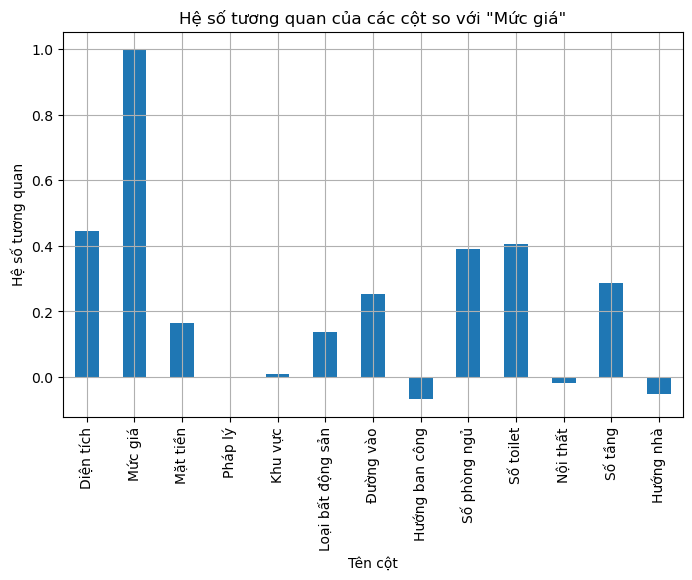

In [22]:
correlations = encode_df.corr()['Mức giá']

plt.figure(figsize=(8, 5))
correlations.plot(kind='bar')

plt.title('Hệ số tương quan của các cột so với "Mức giá"')
plt.ylabel('Hệ số tương quan')
plt.xlabel('Tên cột')
plt.grid(True)
plt.show()

In [23]:
encode_df = encode_df.drop(columns=['Hướng nhà', 'Hướng ban công', 'Pháp lý', 'Nội thất'])
encode_df = encode_df.dropna()
encode_df.to_csv('cleaned_data.csv', index=False)


In [24]:
encode_df.shape

(4107, 9)

In [25]:
unique_values = df['Loại bất động sản'].unique()
unique_values

array(['Bán đất', 'Căn hộ chung cư', 'Nhà riêng', 'Nhà mặt phố', nan,
       'Nhà biệt thự, liền kề', 'Shophouse, nhà phố thương mại',
       'Chung cư mini, căn hộ dịch vụ', 'Loại bất động sản khác',
       'Kho, nhà xưởng', 'Trang trại, khu nghỉ dưỡng', 'Đất nền dự án'],
      dtype=object)

In [26]:
unique_values = df['Khu vực'].unique()
unique_values

array(['Hoàn Kiếm', 'Hoài Đức', 'Nam Từ Liêm', 'Hà Đông', 'Gia Lâm',
       'Sóc Sơn', 'Cầu Giấy', 'Tây Hồ', 'Hoàng Mai', 'Thanh Trì', nan,
       'Chương Mỹ', 'Bắc Từ Liêm', 'Quốc Oai', 'Long Biên', 'Thanh Xuân',
       'Đống Đa', 'Đông Anh', 'Đan Phượng', 'Hai Bà Trưng', 'Thạch Thất',
       'Ba Đình', 'Ba Vì', 'Thường Tín', 'Mỹ Đức', 'Phúc Thọ', 'Mê Linh',
       'Thanh Oai', 'Sơn Tây', 'Phú Xuyên', 'Ứng Hòa'], dtype=object)